In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from childes_mi.utils.paths import DATA_DIR, FIGURE_DIR
from childes_mi.utils.general import flatten,save_fig

In [3]:
from childes_mi.information_theory import model_fitting as mf

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
MI_DF = pd.read_pickle(DATA_DIR/'mi/phonbank_mi.pickle')

In [6]:
MI_DF[:3]

,MI,MI_var,shuff_MI,shuff_MI_var,distances,age_cohort_low,age_cohort_high,n_phones,n_unique_phones
0,"[10.080288260013138, 9.916455549165027, 9.7424...","[0.010088692845104597, 0.009966629345003522, 0...","[9.540319164934521, 9.545878218535728, 9.53434...","[0.009889103513194912, 0.009903386166469113, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.5,1,60390,3259
1,"[11.018700216584904, 10.737645462157055, 10.56...","[0.005213049628772987, 0.005149803969908309, 0...","[10.354873873252643, 10.35376084240053, 10.353...","[0.00508955241492165, 0.005096158572864715, 0....","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1.0,1.5,312914,5787
2,"[11.052948976446858, 10.656466560369868, 10.48...","[0.0044666661484878325, 0.0043938556743630605,...","[10.335267645293385, 10.33318150766475, 10.333...","[0.004350729568225813, 0.004350829245781982, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1.5,2,457938,5769


In [7]:
MI_DF = MI_DF.assign(**{i:np.nan for i in ['exp_results', 'pow_results', 'concat_results',
     'R2_exp', 'R2_concat', 'R2_power', 'AICc_exp',
     'AICc_concat', 'AICc_power', 'bestfitmodel', 'curvature', 'min_peak']})
MI_DF['curvature'] = MI_DF['curvature'].astype(object)

In [8]:
n = 100 # max distance for computation
for idx, row in tqdm(MI_DF.iterrows(), total=len(MI_DF)):
    # get signal
    sig = np.array(row.MI-row.shuff_MI)
    distances = row.distances
    sig = sig
    
    # fit models
    results_power, results_exp, results_pow_exp, best_fit_model = mf.fit_models(distances, sig)
    
    # get fit results
    R2_exp, R2_concat, R2_power, AICc_exp, \
        AICc_pow, AICc_concat = mf.fit_results(sig, distances, 
                                              results_exp, results_power,
                                              results_pow_exp)
    
    
    # get model y
    distances_mod = np.logspace(0,np.log10(n), base=10, num=1000)
    if best_fit_model == 'pow_exp':
        y_model = mf.get_y(mf.pow_exp_decay, results_pow_exp, distances_mod)
    elif best_fit_model == 'exp':
        y_model = mf.get_y(mf.exp_decay, results_exp, distances_mod)
    elif best_fit_model == 'pow':
        y_model = mf.get_y(mf.powerlaw_decay, results_power, distances_mod)
    
    # get curvature of model_y
    curvature_model = mf.curvature(np.log(y_model))
    
    # if the best fit model is pow_exp, then grab the min peak
    if best_fit_model == 'pow_exp':
        # get peaks of curvature
        peaks = np.where((
            (curvature_model[:-1] < curvature_model[1:])[1:] & (curvature_model[1:] < curvature_model[:-1])[:-1]
        ))
        min_peak = peaks[0][0]
    else:
        min_peak = np.nan

    # get save model fit results to MI_DF
    MI_DF.loc[idx, np.array(['exp_results', 'pow_results', 'concat_results',
                         'R2_exp', 'R2_concat', 'R2_power', 'AICc_exp',
                         'AICc_concat', 'AICc_power', 'bestfitmodel', 'curvature', 'min_peak'])] = [
        results_exp, results_power, results_pow_exp,
        R2_exp, R2_concat, R2_power, AICc_exp,
        AICc_concat, AICc_pow, best_fit_model,
        curvature_model, min_peak
    ]

    print(row.age_cohort_low, row.age_cohort_high, best_fit_model)

0.5 1 pow_exp
1.0 1.5 pow_exp
1.5 2 pow_exp
2.0 2.5 pow_exp
2.5 3 pow_exp
3.0 20 pow_exp



In [9]:
MI_DF[:3]

,MI,MI_var,shuff_MI,shuff_MI_var,distances,age_cohort_low,age_cohort_high,n_phones,n_unique_phones,exp_results,...,concat_results,R2_exp,R2_concat,R2_power,AICc_exp,AICc_concat,AICc_power,bestfitmodel,curvature,min_peak
0,"[10.080288260013138, 9.916455549165027, 9.7424...","[0.010088692845104597, 0.009966629345003522, 0...","[9.540319164934521, 9.545878218535728, 9.53434...","[0.009889103513194912, 0.009903386166469113, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.5,1,60390,3259,<lmfit.minimizer.MinimizerResult object at 0x7...,...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.983485,0.993614,0.989926,-573.660113,-664.289186,-623.093092,pow_exp,"[-4.7259173188471115e-07, -7.152342473020701e-...",259.0
1,"[11.018700216584904, 10.737645462157055, 10.56...","[0.005213049628772987, 0.005149803969908309, 0...","[10.354873873252643, 10.35376084240053, 10.353...","[0.00508955241492165, 0.005096158572864715, 0....","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1.0,1.5,312914,5787,<lmfit.minimizer.MinimizerResult object at 0x7...,...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.980861,0.998117,0.995941,-516.601598,-744.125823,-671.671083,pow_exp,"[-6.398269681238529e-07, -9.676437685993425e-0...",247.0
2,"[11.052948976446858, 10.656466560369868, 10.48...","[0.0044666661484878325, 0.0043938556743630605,...","[10.335267645293385, 10.33318150766475, 10.333...","[0.004350729568225813, 0.004350829245781982, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1.5,2,457938,5769,<lmfit.minimizer.MinimizerResult object at 0x7...,...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.971529,0.998164,0.996968,-436.462823,-706.207524,-660.428461,pow_exp,"[-3.526032069378871e-06, -5.3052760008367026e-...",169.0


In [16]:
MI_DF.concat_results.values[0].params

Parameters([('e_init',
             <Parameter 'e_init', value=0.3029242900040985 +/- 0.0713, bounds=[1e-19:inf]>),
            ('e_decay_const',
             <Parameter 'e_decay_const', value=0.36871186196826455 +/- 0.044, bounds=[1e-10:inf]>),
            ('p_init',
             <Parameter 'p_init', value=0.31172166624839215 +/- 0.0471, bounds=[1e-10:inf]>),
            ('p_decay_const',
             <Parameter 'p_decay_const', value=-0.9432332875653395 +/- 0.0784, bounds=[-inf:-1e-10]>),
            ('intercept',
             <Parameter 'intercept', value=0.02527996809903943 +/- 0.00161, bounds=[1e-10:inf]>)])

In [10]:
test = MI_DF.concat_results.values[0].params['p_decay_const']
test

<Parameter 'p_decay_const', value=-0.9432332875653395 +/- 0.0784, bounds=[-inf:-1e-10]>

In [11]:
test.stderr

0.07839749428460403

In [17]:
param = 'e_decay_const'

In [18]:
powerlaw_slope = np.array([i.params[param].value for i in MI_DF.concat_results.values])
powerlaw_slope_stderr = np.array([i.params[param].stderr for i in MI_DF.concat_results.values])

In [19]:
labels = ['6-12 months', '12-18 months', '18-24 months', '24-30 months', '30-36 months', '3-4 years']

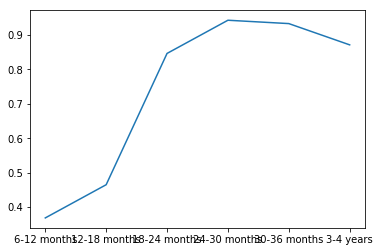

In [20]:
plt.plot(labels, powerlaw_slope)
#plt.fill_between(labels, powerlaw_slope - powerlaw_slope_stderr, powerlaw_slope + powerlaw_slope_stderr, alpha = 0.2)